In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import PolynomialFeatures

In [2]:
df = pd.read_csv("data-p2/filtered_mimic3d.csv")
print(df.head())

   hadm_id gender  age  LOSdays admit_type             admit_location  \
0   100003      M   59     4.04  EMERGENCY       EMERGENCY ROOM ADMIT   
1   100011      M   21    14.38  EMERGENCY  CLINIC REFERRAL/PREMATURE   
2   100036      F   82    10.04  EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3   100060      F   48     4.46  EMERGENCY       EMERGENCY ROOM ADMIT   
4   100069      F   33     0.71  EMERGENCY  PHYS REFERRAL/NORMAL DELI   

                                     AdmitDiagnosis insurance       religion  \
0                                    UPPER GI BLEED   Private  NOT SPECIFIED   
1  MOTOR VEHICLE ACCIDENT WITH UNSPECIFIED INJURIES  Medicaid  NOT SPECIFIED   
2                                               CHF  Medicare       CATHOLIC   
3                                          OVERDOSE  Medicare       CATHOLIC   
4                               ORGAN DONOR ACCOUNT   Private       CATHOLIC   

  marital_status  ... NumMicroLabs  NumNotes  NumOutput  NumRx NumProcEvents  \


### variable investigation

In [3]:
df.dtypes

hadm_id               int64
gender               object
age                   int64
LOSdays             float64
admit_type           object
admit_location       object
AdmitDiagnosis       object
insurance            object
religion             object
marital_status       object
ethnicity            object
NumCallouts         float64
NumDiagnosis        float64
NumProcs            float64
AdmitProcedure       object
NumCPTevents        float64
NumInput            float64
NumLabs             float64
NumMicroLabs        float64
NumNotes            float64
NumOutput           float64
NumRx               float64
NumProcEvents       float64
NumTransfers        float64
NumChartEvents      float64
ExpiredHospital       int64
TotalNumInteract    float64
LOSgroupNum           int64
dtype: object

In [4]:
df = df.drop(columns=['hadm_id','LOSgroupNum'])

In [5]:
ethnicity_mapping = {
    "ASIAN": "ASIAN",
    "ASIAN - ASIAN INDIAN": "ASIAN",
    "ASIAN - CAMBODIAN": "ASIAN",
    "ASIAN - CHINESE": "ASIAN",
    "ASIAN - FILIPINO": "ASIAN",
    "ASIAN - KOREAN": "ASIAN",
    "ASIAN - OTHER": "ASIAN",
    "ASIAN - VIETNAMESE": "ASIAN",
    "BLACK/AFRICAN AMERICAN": "BLACK",
    "BLACK/CAPE VERDEAN": "BLACK",
    "BLACK/HAITIAN": "BLACK",
    "CARIBBEAN ISLAND": "OTHER",
    "HISPANIC OR LATINO": "HISPANIC",
    "HISPANIC/LATINO - CUBAN": "HISPANIC",
    "HISPANIC/LATINO - DOMINICAN": "HISPANIC",
    "HISPANIC/LATINO - GUATEMALAN": "HISPANIC",
    "HISPANIC/LATINO - MEXICAN": "HISPANIC",
    "HISPANIC/LATINO - PUERTO RICAN": "HISPANIC",
    "MIDDLE EASTERN": "OTHER",
    "MULTI RACE ETHNICITY": "OTHER",
    "OTHER": "OTHER",
    "PATIENT DECLINED TO ANSWER": "UNAVAILABLE",
    "PORTUGUESE": "OTHER",
    "SOUTH AMERICAN": "OTHER",
    "UNABLE TO OBTAIN": "UNAVAILABLE",
    "UNKNOWN/NOT SPECIFIED": "UNAVAILABLE",
    "WHITE": "WHITE",
    "WHITE - BRAZILIAN": "WHITE",
    "WHITE - EASTERN EUROPEAN": "WHITE",
    "WHITE - OTHER EUROPEAN": "WHITE",
    "WHITE - RUSSIAN": "WHITE"
}


df['ethnicity'] = df['ethnicity'].map(ethnicity_mapping)

df['ethnicity']


0          WHITE
1       HISPANIC
2          WHITE
3          WHITE
4          WHITE
          ...   
2971       WHITE
2972       WHITE
2973       WHITE
2974       WHITE
2975       WHITE
Name: ethnicity, Length: 2976, dtype: object

In [6]:
df['ethnicity'].value_counts()

ethnicity
WHITE          2081
UNAVAILABLE     298
BLACK           289
ASIAN           118
HISPANIC         97
OTHER            89
Name: count, dtype: int64

In [7]:
religion_mapping = {
    "CATHOLIC": 1,
    "NOT SPECIFIED": 0,
    "UNOBTAINABLE": 0,
    "PROTESTANT QUAKER": 1,
    "JEWISH": 1,
    "OTHER": 1,
    "EPISCOPALIAN": 1,
    "BUDDHIST": 1,
    "GREEK ORTHODOX": 1,
    "MUSLIM": 1,
    "CHRISTIAN SCIENTIST": 1,
    "UNITARIAN-UNIVERSALIST": 1,
    "JEHOVAH'S WITNESS": 1,
    "HINDU": 1,
    "7TH DAY ADVENTIST": 1,
    "BAPTIST": 1
}

df['religion'] = df['religion'].map(religion_mapping).fillna(0).astype(int)



df['religion']

0       0
1       0
2       1
3       1
4       1
       ..
2971    0
2972    1
2973    0
2974    1
2975    0
Name: religion, Length: 2976, dtype: int64

In [8]:
df['religion'].value_counts()

religion
1    1979
0     997
Name: count, dtype: int64

In [9]:
df['gender'] = df['gender'].map({'M': 0, 'F': 1})

In [10]:
# One-hot encode low-cardinality columns
#df_one_hot = pd.get_dummies(df[['gender', 'admit_type', 'admit_location','religion','insurance', 'marital_status','ethnicity',]], drop_first=True)
df_one_hot = pd.get_dummies(df[['admit_type', 'admit_location','insurance', 'marital_status','ethnicity']], drop_first=True).astype(int)

# Binary encode high-cardinality columns
binary_encoder = ce.BinaryEncoder(cols=['AdmitDiagnosis', 'AdmitProcedure'], drop_invariant=True)
df_binary = binary_encoder.fit_transform(df[['AdmitDiagnosis', 'AdmitProcedure']])

# Select numeric columns
df_numeric = df.select_dtypes(include=['float64', 'int64'])
# Concatenate everything
df_concat = pd.concat([df_numeric, df_one_hot, df_binary], axis=1)
df_concat.head()

,gender,age,LOSdays,religion,NumCallouts,NumDiagnosis,NumProcs,NumCPTevents,NumInput,NumLabs,...,AdmitDiagnosis_10,AdmitProcedure_0,AdmitProcedure_1,AdmitProcedure_2,AdmitProcedure_3,AdmitProcedure_4,AdmitProcedure_5,AdmitProcedure_6,AdmitProcedure_7,AdmitProcedure_8
0,0,59,4.04,0,0.25,2.23,0.99,1.98,13.61,55.94,...,1,0,0,0,0,0,0,0,0,1
1,0,21,14.38,0,0.07,0.97,1.04,3.13,62.38,43.46,...,0,0,0,0,0,0,0,0,1,0
2,1,82,10.04,1,0.10,1.69,0.30,0.10,30.08,43.53,...,1,0,0,0,0,0,0,0,1,1
3,1,48,4.46,1,0.00,1.79,0.22,2.02,6.50,32.51,...,0,0,0,0,0,0,0,1,0,0
4,1,33,0.71,1,0.00,1.41,0.00,1.41,415.49,460.56,...,1,0,0,0,0,0,0,1,0,1


In [24]:
# df_concat.to_csv("data-p2/encoded_filtered_mimic3d.csv",index=False)

In [25]:
# df_concat.columns[df_concat.columns.duplicated()]

In [11]:
df_concat = df_concat.loc[:, ~df_concat.columns.duplicated()]

In [30]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
interaction_terms = poly.fit_transform(df_concat)

X_pre = df_concat.drop(columns=['LOSdays']) # Replace with your actual variables
y_pre = df_concat['LOSdays']

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X_pre)

df_interactions = pd.DataFrame(X_interactions, columns=poly.get_feature_names_out(X_pre.columns))
df_interactions['LOSdays'] = y_pre



### mutual info

In [15]:
X = df_interactions.drop(columns=['LOSdays']) # Replace with your actual variables
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
discrete_features = X.dtypes == int
y = df_interactions['LOSdays']

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores # show a few features with their MI scores

C:\Users\mairi\AppData\Local\Temp\ipykernel_19020\3037096851.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


NumTransfers                                                 2.483422
NumTransfers admit_type_EMERGENCY                            1.600125
NumTransfers ethnicity_WHITE                                 1.566687
NumCallouts                                                  1.435559
religion NumTransfers                                        1.419386
                                                               ...   
AdmitProcedure_4 AdmitProcedure_5                            0.000000
AdmitProcedure_3 AdmitProcedure_6                            0.000000
admit_location_TRANSFER FROM SKILLED NUR AdmitProcedure_3    0.000000
AdmitProcedure_3 AdmitProcedure_4                            0.000000
AdmitProcedure_2 AdmitProcedure_8                            0.000000
Name: MI Scores, Length: 1953, dtype: float64

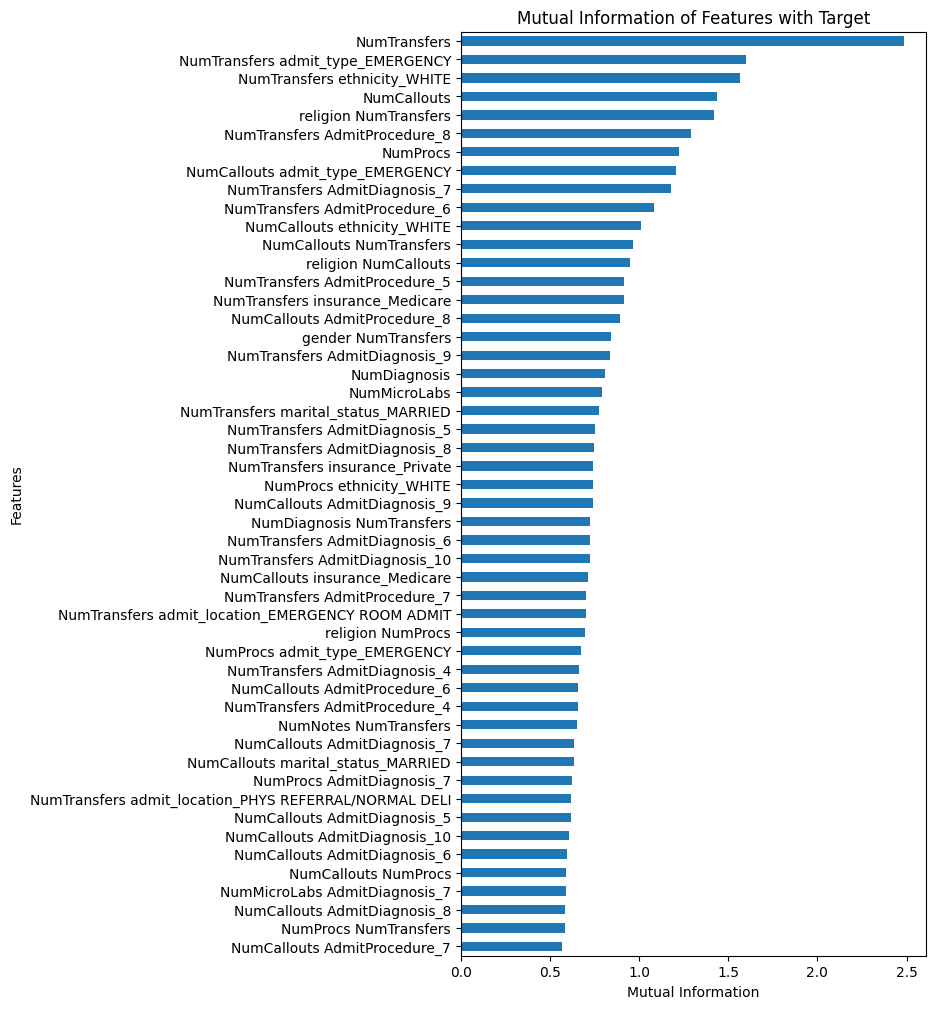

In [16]:
plt.figure(figsize=(6, 12))  # Adjust size as needed
mi_scores.head(50).plot(kind='barh')
plt.title('Mutual Information of Features with Target')
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest MI scores at the top
plt.show()

In [33]:
df_interactions.shape[1]

1954

### random forest

In [34]:
from sklearn.ensemble import RandomForestRegressor #, RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# For Regression:
model = RandomForestRegressor(n_estimators=200, random_state=42)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [35]:
y_pred = model.predict(X_test)

# Calculate the performance metrics, e.g., R² score
from sklearn.metrics import r2_score
print(f"R² score on the test set: {r2_score(y_test, y_pred)}")

R² score on the test set: 0.7887468906976454


In [36]:
model.feature_importances_

array([1.93134354e-04, 2.46818261e-04, 2.35137158e-05, ...,
       1.34008500e-05, 2.96432011e-05, 6.39660390e-05])

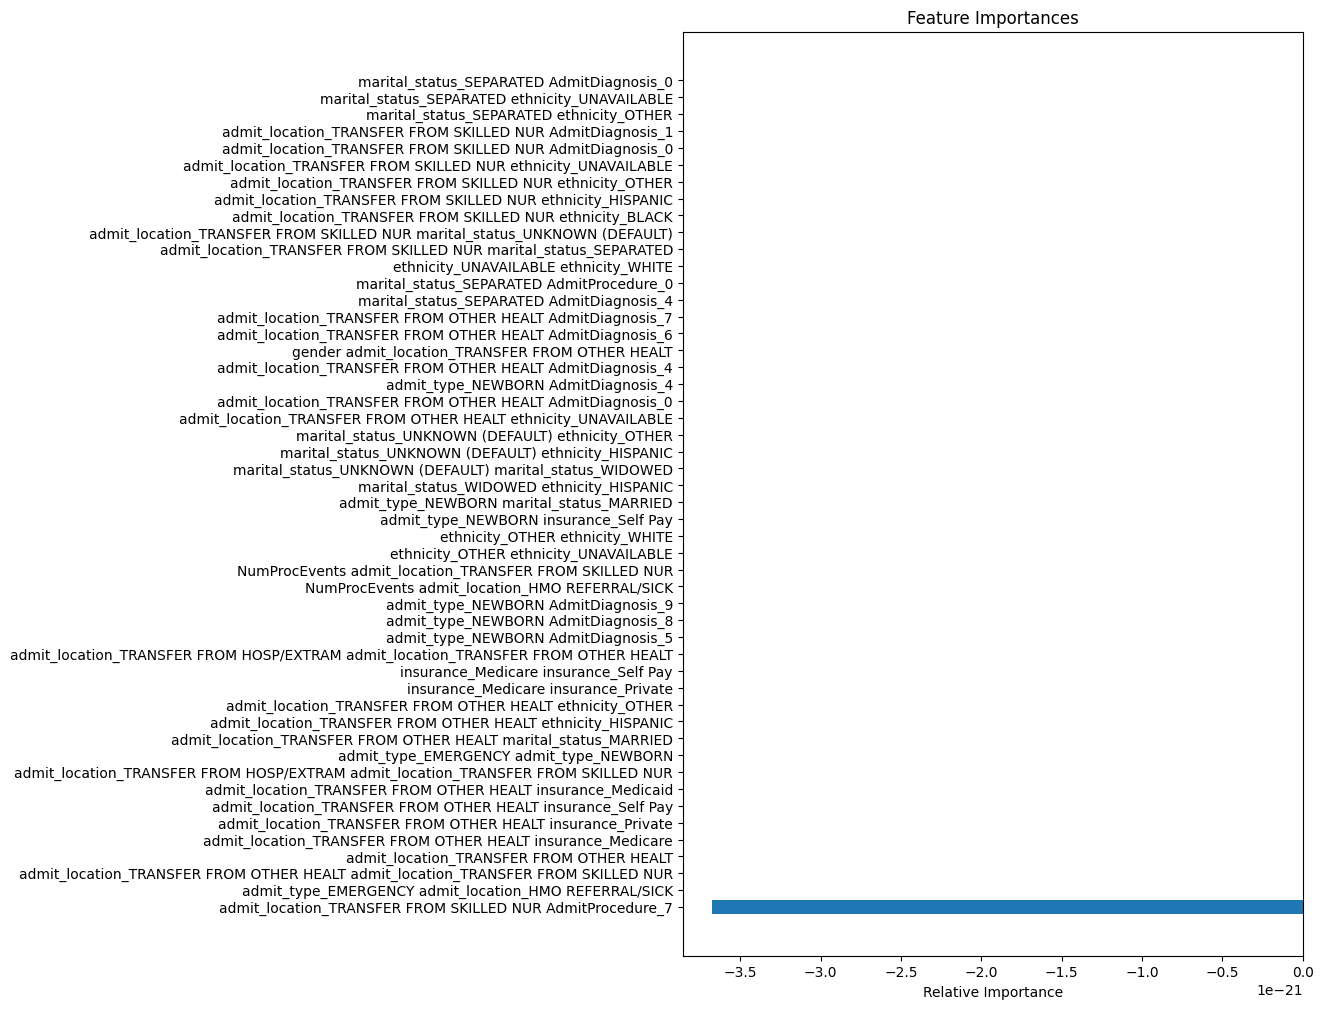

In [39]:
importances = model.feature_importances_

indices = np.argsort(importances)

plt.figure(figsize=(8, 12))
plt.title("Feature Importances")

# Modify to show only the first 50 features
top_n = 50
plt.barh(range(top_n), importances[indices][:top_n], align="center")
plt.yticks(range(top_n), np.array(X.columns)[indices][:top_n])

plt.xlabel("Relative Importance")
plt.show()

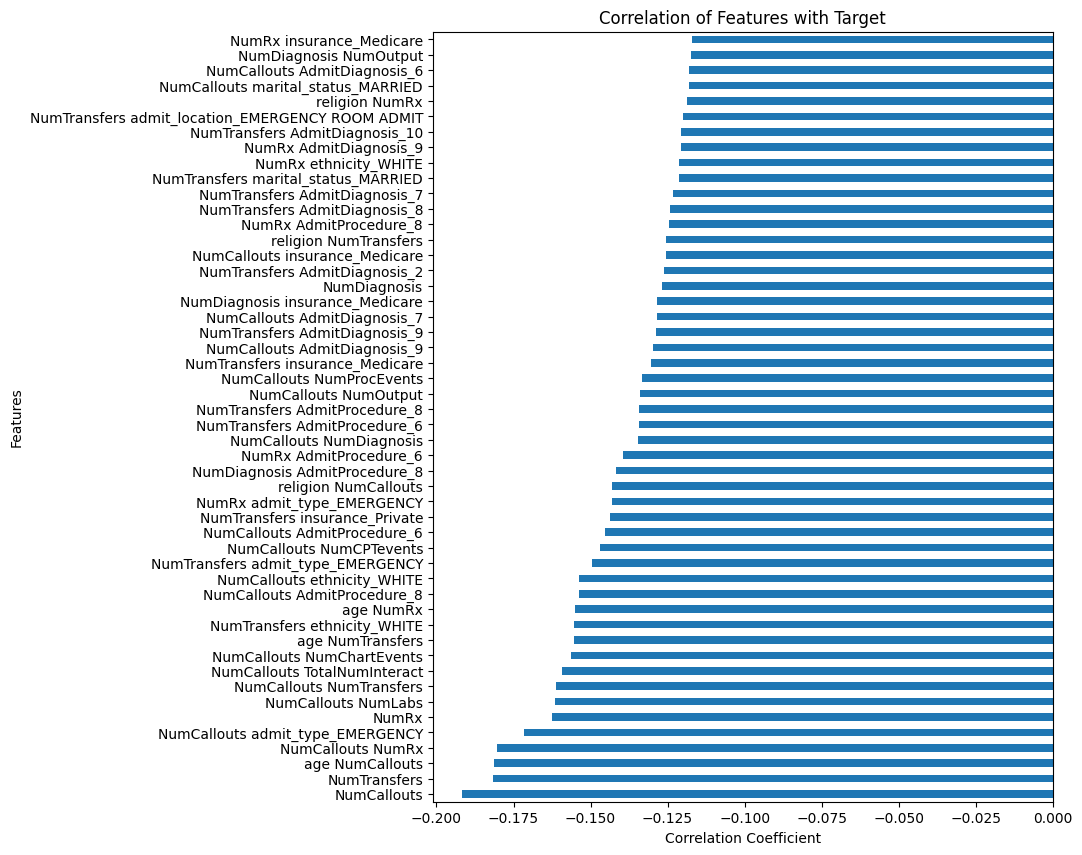

In [40]:
corr_matrix = df_interactions.corr()

# Extract the correlation of each feature with the target variable
target_corr = corr_matrix['LOSdays'].drop('LOSdays')  # Drop the target itself from the list

# Display the correlation coefficients
# print(target_corr)

plt.figure(figsize=(8, 10))
target_corr.sort_values().head(50).plot(kind='barh')
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

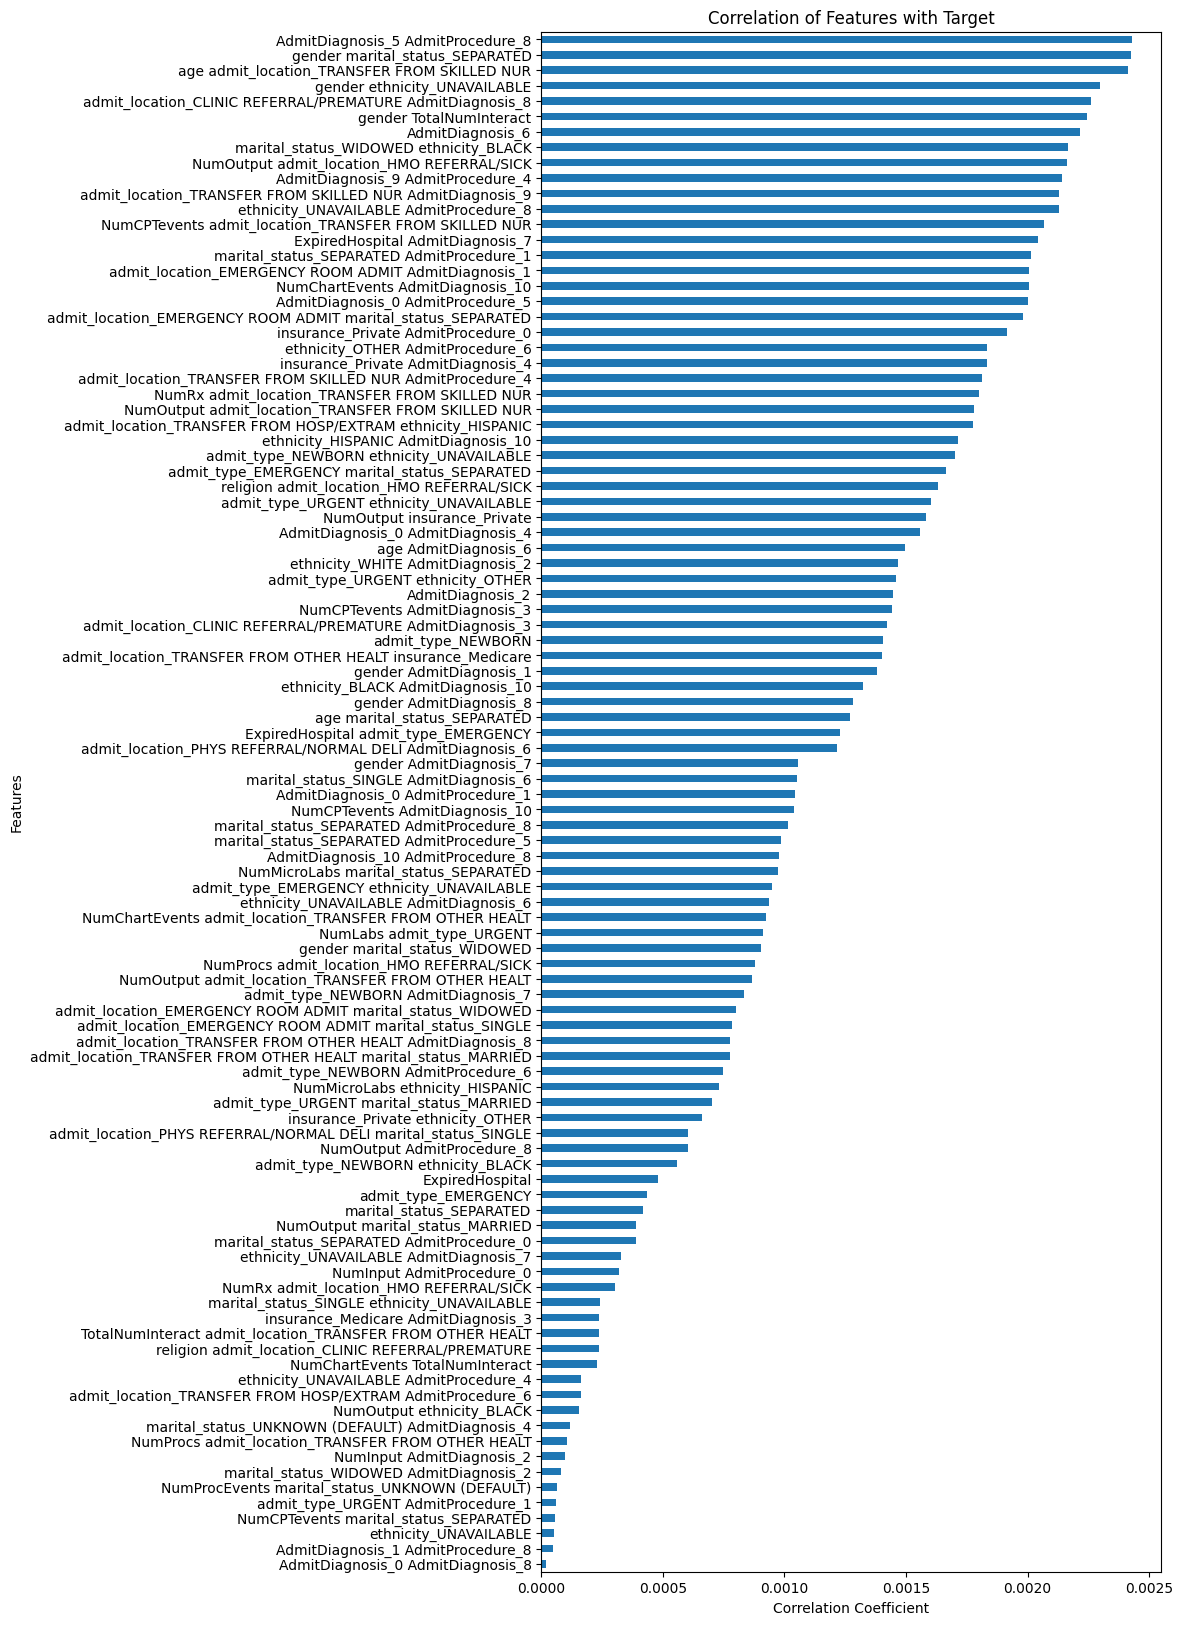

In [45]:
target_corr_abs = target_corr.abs()
plt.figure(figsize=(8, 20))
target_corr_abs.sort_values().head(100).plot(kind='barh')
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [46]:
ranking_df = pd.DataFrame({
    'Feature': X.columns,  # Features from your dataset
    'MI Score': mi_scores,
    'Random Forest': importances,
    'Correlation': target_corr_abs
},index=X.columns)

# Rank features for each method (rankings start from 1, with the lowest score being most important)
ranking_df['MI Rank'] = ranking_df['MI Score'].rank(ascending=False)
ranking_df['RF Rank'] = ranking_df['Random Forest'].rank(ascending=False)
ranking_df['Corr Rank'] = ranking_df['Correlation'].rank(ascending=False)

# Compute the overall rank by summing the ranks for each feature
ranking_df['Overall Rank Raw'] = ranking_df[['MI Rank', 'RF Rank', 'Corr Rank']].sum(axis=1)

ranking_df['Overall Rank'] = ranking_df['Overall Rank Raw'].rank(ascending=True)
ranking_df = ranking_df.drop(columns=['Overall Rank Raw'])

# Sort features by their overall rank (the lower the rank, the better the feature)
ranking_df = ranking_df.sort_values(by='Overall Rank')

# Display the ranked features
ranking_df[['MI Rank', 'RF Rank', 'Corr Rank', 'Overall Rank']].head(10)

,MI Rank,RF Rank,Corr Rank,Overall Rank
NumTransfers,1.0,2.0,2.0,1.0
NumCallouts,4.0,60.0,1.0,2.0
NumDiagnosis,19.0,10.0,39.0,3.0
NumTransfers admit_type_EMERGENCY,2.0,87.0,18.0,4.0
NumCallouts NumTransfers,12.0,95.0,10.0,5.0
NumTransfers AdmitDiagnosis_7,9.0,67.0,46.0,6.0
age NumTransfers,55.0,91.0,13.0,7.0
NumCallouts AdmitDiagnosis_5,43.0,66.0,65.0,8.0
NumCallouts NumDiagnosis,81.0,73.0,29.0,9.0
NumCallouts AdmitProcedure_5,59.0,40.0,85.0,10.0


In [47]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()

scaled_df= pd.DataFrame()
# Scale the column
scaled_df['feature'] = ranking_df['Feature']
scaled_df['mi_scaled'] = scaler.fit_transform(ranking_df[['MI Score']]).flatten()
scaled_df['rf_scaled'] = scaler.fit_transform(ranking_df[['Random Forest']]).flatten()
scaled_df['corr_scaled'] = scaler.fit_transform(ranking_df[['Correlation']]).flatten()

scaled_df['overall_scaled'] = scaled_df[['mi_scaled','rf_scaled','corr_scaled']].sum(axis=1)
scaled_df = scaled_df.sort_values(by='overall_scaled',ascending=False)

In [48]:
scaled_df.head(20)

,feature,mi_scaled,rf_scaled,corr_scaled,overall_scaled
NumTransfers,NumTransfers,1.000000,0.231458,0.947397,2.178855
NumCallouts,NumCallouts,0.578057,0.002029,1.000000,1.580086
NumDiagnosis NumTransfers,NumDiagnosis NumTransfers,0.292805,1.000000,0.163919,1.456724
NumTransfers ethnicity_WHITE,NumTransfers ethnicity_WHITE,0.630858,0.000536,0.810136,1.441530
NumTransfers admit_type_EMERGENCY,NumTransfers admit_type_EMERGENCY,0.644323,0.001502,0.780371,1.426196
NumCallouts admit_type_EMERGENCY,NumCallouts admit_type_EMERGENCY,0.486692,0.000536,0.895406,1.382634
NumCallouts NumTransfers,NumCallouts NumTransfers,0.388679,0.001387,0.841139,1.231204
religion NumTransfers,religion NumTransfers,0.571545,0.000856,0.655211,1.227612
NumTransfers AdmitProcedure_8,NumTransfers AdmitProcedure_8,0.519953,0.000531,0.699947,1.220431
NumCallouts ethnicity_WHITE,NumCallouts ethnicity_WHITE,0.406987,0.000444,0.801741,1.209173


<Axes: >

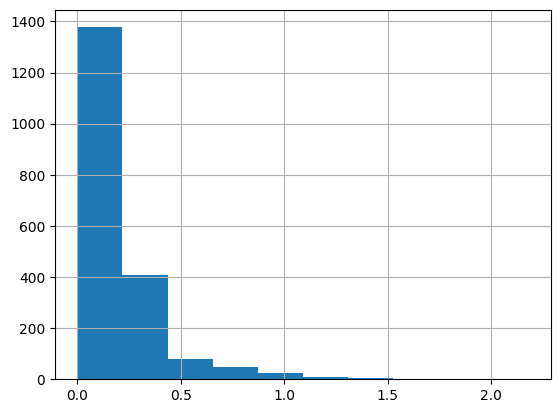

In [49]:
scaled_df['overall_scaled'].hist()

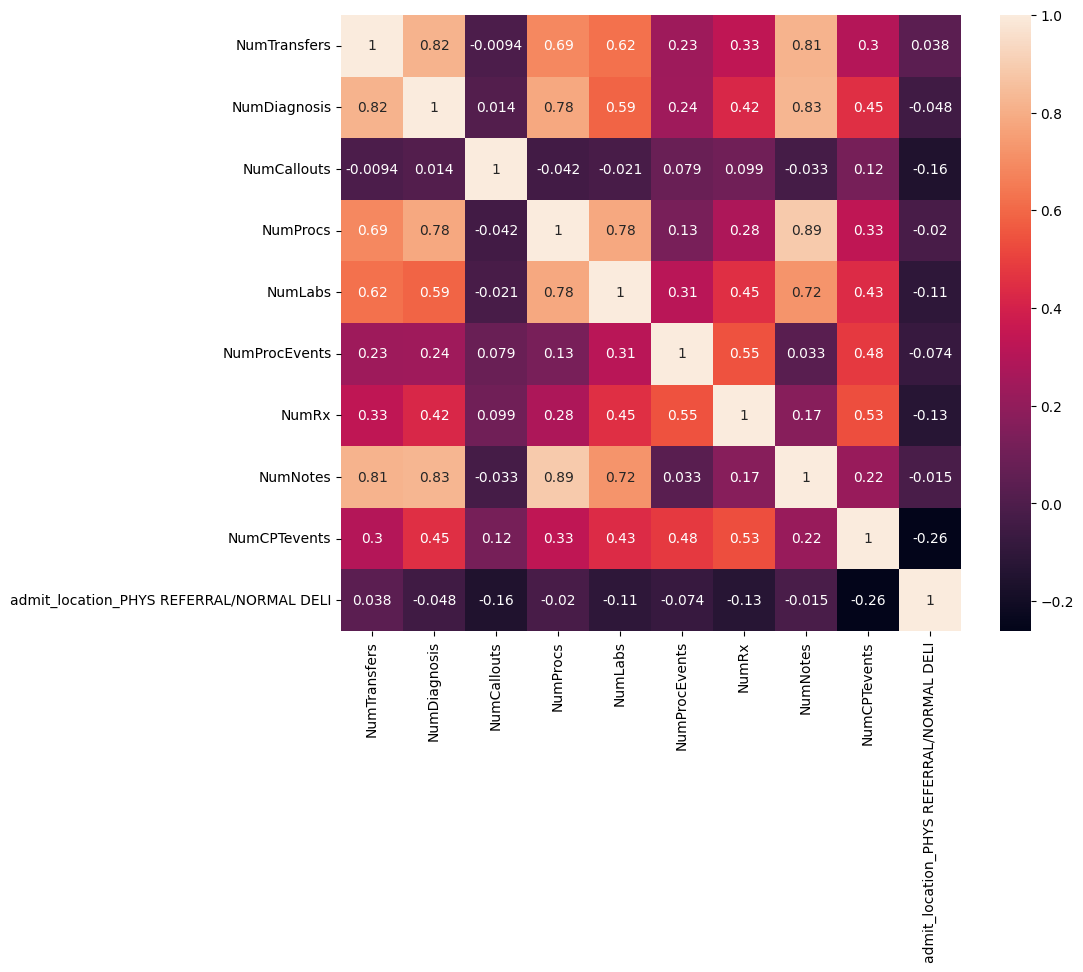

In [64]:
df_interactions_filt = df_concat[['NumTransfers','NumCallouts','NumDiagnosis NumTransfers','NumProcs','NumLabs','NumProcEvents','NumRx','NumNotes','NumCPTevents','admit_location_PHYS REFERRAL/NORMAL DELI']]
correlation_matrix = df_concat_filt.corr()
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Conclusion - going to try NumTransfers NumCallouts